In [130]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
 
# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  99


In [131]:
dataroot = "./datasets/content_blend/images"
 
# 数据加载器的工作进程数
workers = 10# 2
 
# 训练过程中的批量大小
batch_size = 128
 
# 训练图像的空间尺寸 所有图像将使用变换器调整为此尺寸
image_size = 64
 
# 训练图像中的通道数
nc = 3
 
# z潜在向量的尺寸（生成器的输入大小）
nz = 100
 
# 生成器中特征图的尺寸
ngf = 64
 
# 判别器中特征图的尺寸
ndf = 64
 
# 训练的周期数
num_epochs = 1
 
# 优化器的学习率
lr = 0.0002
 
# Adam优化器的Beta1超参数
beta1 = 0.5
 
ngpu = 2

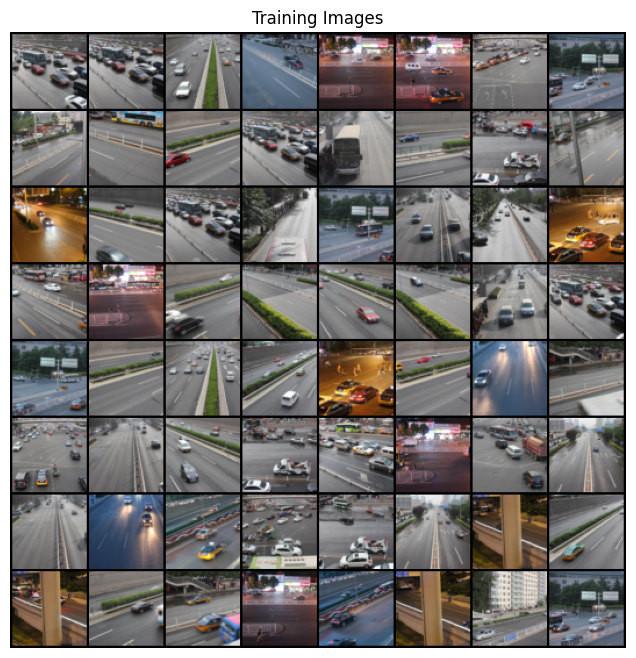

In [132]:
# 创建数据集
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# 创建数据加载器
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)
 
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
 
# 可视化一些训练图像
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [133]:
# 自定义权重初始化
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [134]:
# 生成器代码
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 状态尺寸. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 状态尺寸. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 状态尺寸. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 状态尺寸. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # 状态尺寸. (nc) x 64 x 64
        )
        """
        上卷积层可理解为是卷积层的逆运算。
        拿最后一个上卷积层举例。若卷积的输入是(nc) x 64 x 64时，
        经过Hout=（Hin+2*Padding-kernel_size）/stride+1=(64+2*1-4)/2+1=32,输出为（out_channels） x 32 x 32
        此处上卷积层为卷积层的输入输出的倒置：
        即输入通道数为out_channels，输出通道数为3；输入图片大小为（out_channels） x 32 x 32，输出图片的大小为(nc) x 64 x 64
        """
 
    def forward(self, input):
        return self.main(input)

In [135]:
# 创建生成器
netG = Generator(ngpu).to(device)
 
# 如果需要，初始化权重
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
 
# 初始化所有权重
netG.apply(weights_init)
 
# 打印生成器信息
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [136]:
# 判别器代码
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 输入是 (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态尺寸. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态尺寸. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态尺寸. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态尺寸. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
 
    def forward(self, input):
        return self.main(input)

In [137]:
# 创建判别器
netD = Discriminator(ngpu).to(device)
 
# 如果需要，初始化权重
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
 
# 初始化所有权重
netD.apply(weights_init)
 
# 打印判别器信息
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [138]:
# 初始化二进制交叉熵损失函数
criterion = nn.BCELoss()
 
# 创建一个批次的潜在向量，这些向量将用于可视化生成器的进度
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
 
# 真实标签是1，假标签是0
real_label = 1.
fake_label = 0.
 
# 为G和D设置Adam优化器
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [139]:
# 训练循环
import cv2
 
# 保持生成器和判别器的损失的进度
img_list = []
G_losses = []
D_losses = []
iters = 0
 
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
 
        ############################
        # (1) 更新D网络: 最大化 log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
 
        ## 用全假图像训练D
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
 
        ############################
        # (2) 更新G网络: 最大化 log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  

        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
 
        if i % 50 == 0:
            print('[%d/%d][%3.d/%3.d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
 
        # 保存损失以供以后绘图
        G_losses.append(errG.item())
        D_losses.append(errD.item())
 
        # 检查生成器的输出
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                print("保存图片")
                cv2.imwrite('./gan/fake_samples_epoch_%03d_%03d.png' % (epoch, i), fake[0].numpy().transpose(1, 2, 0))

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
             
        iters += 1

Starting Training Loop...


[0/1][  0/1095]	Loss_D: 2.0451	Loss_G: 5.4825	D(x): 0.4217	D(G(z)): 0.5658 / 0.0077
保存图片
[0/1][ 50/1095]	Loss_D: 0.2908	Loss_G: 9.5205	D(x): 0.9128	D(G(z)): 0.1349 / 0.0001
[0/1][100/1095]	Loss_D: 0.1355	Loss_G: 5.1194	D(x): 0.9309	D(G(z)): 0.0547 / 0.0133
[0/1][150/1095]	Loss_D: 0.0451	Loss_G: 6.9660	D(x): 0.9628	D(G(z)): 0.0021 / 0.0017
[0/1][200/1095]	Loss_D: 0.1771	Loss_G: 7.8421	D(x): 0.9751	D(G(z)): 0.1289 / 0.0007
[0/1][250/1095]	Loss_D: 0.0919	Loss_G: 6.9017	D(x): 0.9464	D(G(z)): 0.0322 / 0.0014
[0/1][300/1095]	Loss_D: 0.1149	Loss_G: 6.0658	D(x): 0.9758	D(G(z)): 0.0778 / 0.0057
[0/1][350/1095]	Loss_D: 0.4501	Loss_G: 9.7753	D(x): 0.9928	D(G(z)): 0.2643 / 0.0004
[0/1][400/1095]	Loss_D: 0.3032	Loss_G: 3.6443	D(x): 0.7913	D(G(z)): 0.0107 / 0.0581
[0/1][450/1095]	Loss_D: 0.5098	Loss_G: 2.7227	D(x): 0.6919	D(G(z)): 0.0186 / 0.1334
[0/1][500/1095]	Loss_D: 0.0910	Loss_G: 5.5342	D(x): 0.9752	D(G(z)): 0.0601 / 0.0092
保存图片
[0/1][550/1095]	Loss_D: 0.2739	Loss_G: 3.6634	D(x): 0.8803	D(G(z))

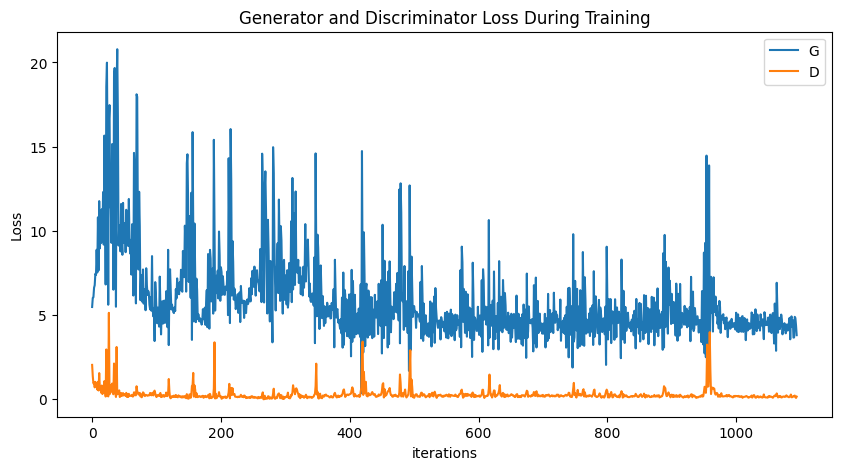

In [140]:
# 打印生成器和判别器的损失
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

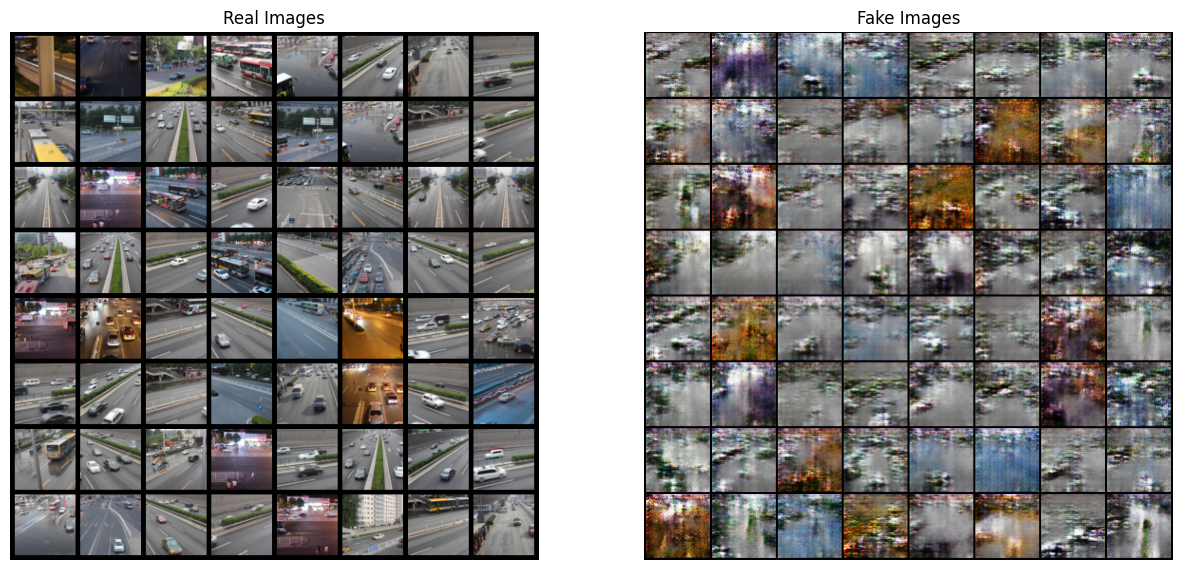

In [141]:
real_batch = next(iter(dataloader))
 
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
 
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [142]:
# 查看图片数量
print(img_list)

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5152,  ..., 0.4737, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.4958,  ..., 0.5485, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4733,  ..., 0.4880, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.5293,  ..., 0.5429, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5496,  ..., 0.5022, 0.0000, 0

In [143]:
images = img_list[-1]

for i in range(len(images)):
    vutils.save_image(images[i], './fake_images/fake_image'+str(i)+'.png')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/文档/GitHub/DL大作业/fake_images/fake_image0.png'